In [1]:
import torch
from IPython.display import display
from PIL import Image
from transformers import ColQwen2ForRetrieval, ColQwen2Processor
from peft import PeftModel


def get_torch_device(device: str = "auto") -> str:
    """
    Returns the device (string) to be used by PyTorch.

    `device` arg defaults to "auto" which will use:
    - "cuda:0" if available
    - else "mps" if available
    - else "cpu".
    """
    if device == "auto":
        if torch.cuda.is_available():
            device = "cuda:0"
        elif torch.backends.mps.is_available():  # for Apple Silicon
            device = "mps"
        else:
            device = "cpu"

    return device

def scale_image(image: Image.Image, new_height: int = 1024) -> Image.Image:
    """
    Scale an image to a new height while maintaining the aspect ratio.
    """
    # Calculate the scaling factor
    width, height = image.size
    aspect_ratio = width / height
    new_width = int(new_height * aspect_ratio)

    # Resize the image
    scaled_image = image.resize((new_width, new_height))

    return scaled_image

/home/linux/anaconda3/envs/cp_ft/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = get_torch_device("auto")

print(f"Using device: {device}")


# 加载 tokenizer 和基座模型
base_model_path = "/home/linux/yyj/colpali/finetune/colqwen2-v1.0-hf"
base_model = ColQwen2ForRetrieval.from_pretrained(
    base_model_path,
    torch_dtype=torch.bfloat16,
    device_map="cuda:0",
)
# 加载微调后的 adapter（LoRA 权重）
adapter_path = "/home/linux/yyj/colpali/finetune/wiky_city_zh_0622_b5_lr2e4_colqwen"
model = PeftModel.from_pretrained(base_model, adapter_path)
processor = ColQwen2Processor.from_pretrained(adapter_path)


Using device: cuda:0


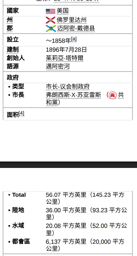

In [3]:
# Load the image and query inputs
image_filepath = "/home/linux/yyj/colpali/finetune/pdf2images_all_splits/Miami/page_003_5.png"
# image_filepath = "/home/linux/yyj/colpali/finetune/pdf2images/Abu_Dhabi/page_002.png"

images = [Image.open(image_filepath)]

# queries = ["亞洲帕拉林匹克委員會總部"]
queries = ["迈阿密市长是谁？"]
# queries = ["博物館"]

# Preview the input images
for image in images:
    display(scale_image(image, 256))

In [4]:
# Preprocess inputs
batch_images = processor(images=image).to(model.device)
batch_queries = processor(text=queries).to(model.device)
print(batch_queries)
# Forward pass
with torch.no_grad():
    image_embeddings = model(**batch_images).embeddings
    query_embeddings = model(**batch_queries).embeddings
print(image_embeddings)
print(query_embeddings)

{'input_ids': tensor([[  2859,     25,  32181,    230,  99727,  27641, 102975, 105518,  11319,
         151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643, 151643,
         151643]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0')}
tensor([[[ 0.0048, -0.0752, -0.0762,  ...,  0.0845,  0.0349,  0.0903],
         [ 0.0245, -0.0962, -0.0200,  ...,  0.0688, -0.0220, -0.1475],
         [ 0.0082, -0.0840, -0.0088,  ...,  0.0645, -0.0074, -0.1416],
         ...,
         [ 0.0391, -0.1318, -0.0972,  ...,  0.0618,  0.0508,  0.0679],
         [ 0.0342, -0.0947, -0.0179,  ...,  0.0271, -0.0039, -0.1533],
         [ 0.0623, -0.0183, -0.0552,  ..., -0.0688,  0.0583, -0.1484]]],
       device='cuda:0', dtype=torch.bfloat16)
tensor([[[ 0.0042, -0.0767, -0.0737,  ...,  0.0850,  0.0325,  0.0898],
         [ 0.0042, -0.0903, -0.0092,  ...,  0.0625, -0.0052, -0.1465],
         [ 0.0184, -0.0874, -0.0041,  ...,  0.

In [5]:
scores = processor.score_retrieval(query_embeddings, image_embeddings)  # (n_queries, n_images)

scores

tensor([[17.3750]], dtype=torch.bfloat16)

In [6]:
import pprint
from typing import Tuple

import matplotlib.pyplot as plt
from colpali_engine.interpretability import (
    get_similarity_maps_from_embeddings,
    plot_all_similarity_maps,
    plot_similarity_map,
)
from transformers import BatchFeature, ProcessorMixin
from transformers.models.qwen2_vl.image_processing_qwen2_vl import smart_resize


def get_n_patches(
    processor: ColQwen2Processor,
    image_size: Tuple[int, int],
    spatial_merge_size: int,
) -> Tuple[int, int]:
    """
    Get the number of patches created by the processor along each dimension of the image.
    """
    patch_size = processor.image_processor.patch_size

    height_new, width_new = smart_resize(
        width=image_size[0],
        height=image_size[1],
        factor=patch_size * processor.image_processor.merge_size,
        min_pixels=processor.image_processor.size["shortest_edge"],
        max_pixels=processor.image_processor.size["longest_edge"],
    )

    n_patches_x = width_new // patch_size // spatial_merge_size
    n_patches_y = height_new // patch_size // spatial_merge_size

    return n_patches_x, n_patches_y


def get_image_mask(processor: ProcessorMixin, batch_images: BatchFeature) -> torch.Tensor:
    """
    Get a tensor mask that identifies the image tokens in the batch.
    """
    image_token_id = processor.tokenizer.convert_tokens_to_ids(processor.image_token)
    return batch_images.input_ids == image_token_id

In [7]:
from typing import List
# Get the number of patches and the image mask for each image of the batch
batched_n_patches: List[Tuple[int, int]] = []  # [(n_patches_x, n_patches_y), ...]


n_patches = get_n_patches(
    processor=processor,
    image_size=image.size,
    spatial_merge_size=model.vlm.config.vision_config.spatial_merge_size,
)
batched_n_patches.append(n_patches)

image_mask = get_image_mask(processor=processor, batch_images=batch_images)

# Batch-compute the similarity maps
batched_similarity_maps = get_similarity_maps_from_embeddings(
    image_embeddings=image_embeddings,
    query_embeddings=query_embeddings,
    n_patches=batched_n_patches,
    image_mask=image_mask,
)

print("For the first image:")
print(f"  - Number of image patches: {batched_n_patches[0]}")
print(f"  - Similarity map shape: (query_length, n_patches_x, n_patches_y) = {tuple(batched_similarity_maps[0].shape)}")

For the first image:
  - Number of image patches: (16, 30)
  - Similarity map shape: (query_length, n_patches_x, n_patches_y) = (19, 16, 30)


In [8]:
idx = 0
input_ids = batch_queries.input_ids[idx]   # 25 Tensor of shape (L,)
all_tokens = processor.tokenizer.convert_ids_to_tokens(input_ids)
# 过滤掉 pad 和 augmentation tokens，保留 (index, id) 对
pad_tok = processor.tokenizer.pad_token_id
aug_tok = processor.query_augmentation_token  # 如果 processor 里有对应 .id 属性
print(f'pad: {pad_tok}, aug: {aug_tok}')
filtered = [
    (i, input_ids[i].item())
    for i in range(len(input_ids))
    if input_ids[i].item() not in {pad_tok, aug_tok}
]
print(filtered)
# 打印下标 & 真正解码出的字符
for i, tok_id in filtered:
    char = processor.tokenizer.decode([tok_id], clean_up_tokenization_spaces=True)
    print(f"{i:3d} -> id={tok_id:5d} -> '{char}'")


pad: 151643, aug: <|endoftext|>
[(0, 2859), (1, 25), (2, 32181), (3, 230), (4, 99727), (5, 27641), (6, 102975), (7, 105518), (8, 11319)]
  0 -> id= 2859 -> 'Query'
  1 -> id=   25 -> ':'
  2 -> id=32181 -> ' �'
  3 -> id=  230 -> '�'
  4 -> id=99727 -> '阿'
  5 -> id=27641 -> '密'
  6 -> id=102975 -> '市长'
  7 -> id=105518 -> '是谁'
  8 -> id=11319 -> '？'


In [9]:
# While all similarity maps are computed, we will only visualize the idx-th one
idx = 0
similarity_maps = batched_similarity_maps[idx]  # (query_length, n_patches_x, n_patches_y)

# Remove the padding tokens and the query augmentation tokens
query_content = processor.decode(batch_queries.input_ids[idx])
query_content = query_content.replace(processor.tokenizer.pad_token, "")
query_content = query_content.replace(processor.query_augmentation_token, "").strip()
print(query_content)
# Retokenize the cleaned query
query_tokens = processor.tokenizer.tokenize(query_content)

# Use this cell output to choose a token using its index
pprint.pprint({idx: val for idx, val in enumerate(query_tokens)})

Query: 迈阿密市长是谁？
{0: 'Query',
 1: ':',
 2: 'Ġè¿',
 3: 'Ī',
 4: 'éĺ¿',
 5: 'å¯Ĩ',
 6: 'å¸Ĥéķ¿',
 7: 'æĺ¯è°ģ',
 8: 'ï¼Ł'}


Selected token: `å¸Ĥéķ¿`


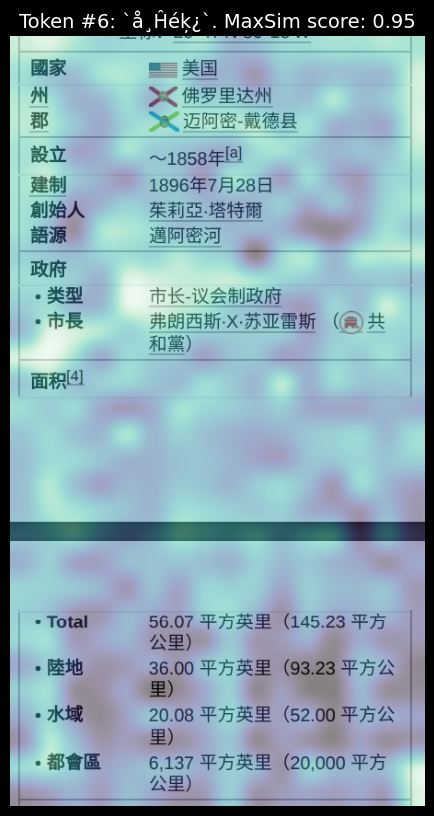

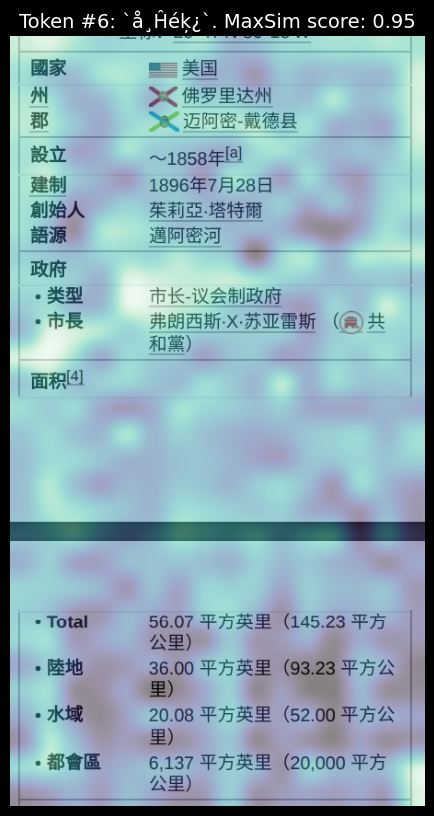

In [10]:
# Choose a token using its index
token_idx = 6  # e.g. if "20: 'Ġmer',", set to 20 to choose the token 'Ġmer'

print(f"Selected token: `{query_tokens[token_idx]}`")

# Retrieve the similarity map for the chosen token
current_similarity_map = similarity_maps[token_idx]  # (n_patches_x, n_patches_y)

fig, ax = plot_similarity_map(
    image=images[0],
    similarity_map=current_similarity_map,
    figsize=(8, 8),
    show_colorbar=False,
)

max_sim_score = similarity_maps[token_idx, :, :].max().item()
ax.set_title(f"Token #{token_idx}: `{query_tokens[token_idx]}`. MaxSim score: {max_sim_score:.2f}", fontsize=14)

fig